## Метрика оценивания соревнования на Kaggle

Метрикой оценки является процент верно классифицированных пассажиров, т.е. точность(accuracy).

## Загрузка библиотек

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [20]:
sns.set(rc={'figure.figsize' : (7, 5)})
sns.color_palette("pastel")
sns.set_style("ticks") 

## Функция для вывода метрик оценки модели

In [21]:
def metrics_summary(y_pred, y_pred_proba, model):
    print('\033[4mAccuracy\033[0m: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('ROC-AUC: ', roc_auc_score(y_test, y_pred_proba))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_),
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()

## Функция для подбора параметров модели

In [22]:
def find_best_parameters(X_train, y_train, model):
    
    parameters = {'iterations' : range(5, 150, 5),
                  'learning_rate': [0.01, 0.05, 0.1],
                  'max_depth': range(3, 13, 2)}

    kf = StratifiedKFold(n_splits=5,
                         shuffle=True,
                         random_state=42)

    grid_search_cv = GridSearchCV(estimator=model,
                                  param_grid=parameters,
                                  cv=kf,
                                  scoring='accuracy')
                                  
    grid_search_cv.fit(X_train, y_train)

    print("Лучшие параметры модели: ", grid_search_cv.best_params_)
    
    return grid_search_cv.best_estimator_

## Загрузка данных

In [23]:
train_df = pd.read_csv('data/preprocessed_data/train.csv')
test_df = pd.read_csv('data/preprocessed_data/test.csv')

Сохраняю PassengerId для создания файла с прогнозом и загрузки решения на Kaggle

In [24]:
submission = pd.DataFrame(test_df["PassengerId"])

## Создание признаков Relatives и IsAlone

In [25]:
for df in [train_df, test_df]:
    df['Relatives'] = df['SibSp'] + df['Parch']
    df.loc[df['Relatives'] > 0, 'IsAlone'] = 0
    df.loc[df['Relatives'] == 0, 'IsAlone'] = 1
for df in [train_df, test_df]:
    df['IsAlone'] = df['IsAlone'].astype(int)

Удаляю признаки _SibSp_ и _Parch_ по скольку при наличии нового признака _Relatives_ они не будут нести для модели никакой новой информации. PassengerId нужен только для файла с прогнозами.

In [26]:
for df in [train_df, test_df]:
    df.drop(['SibSp'], axis=1, inplace=True)
    df.drop(['Parch'], axis=1, inplace=True)
    df.drop(['PassengerId'], axis=1, inplace=True)

## Создание фиктивных признаков и стандартизация числовых

Использую метод get_dummies, который создает k-1 признаков из категориальных, где k - кол-во групп. Например порт посадки _Embarked_ имеет 3 различных значений, будет созданно 2 фиктивных признака.

In [27]:
train_df = pd.get_dummies(train_df, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype=int)
test_df = pd.get_dummies(test_df, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype=int)

In [28]:
scaler = StandardScaler()
train_df[['Age', 'Fare', 'Relatives']] = scaler.fit_transform(train_df[['Age', 'Fare', 'Relatives']])
test_df[['Age', 'Fare', 'Relatives']] = scaler.fit_transform(test_df[['Age', 'Fare', 'Relatives']])

## Итоговый вид датафреймов

In [29]:
train_df.head()

,Survived,Age,Fare,Relatives,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,-0.592481,-0.502445,0.059160,0,0,1,1,0,1
1,1,0.638789,0.786845,0.059160,0,0,0,0,0,0
2,1,-0.284663,-0.488854,-0.560975,1,0,1,0,0,1
3,1,0.407926,0.420730,0.059160,0,0,0,0,0,1
4,0,0.407926,-0.486337,-0.560975,1,0,1,1,0,1


In [30]:
test_df.head()

,Age,Fare,Relatives,IsAlone,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.344284,-0.498258,-0.553443,1,0,1,1,1,0
1,1.334655,-0.513125,0.105643,0,0,1,0,0,1
2,2.523099,-0.464940,-0.553443,1,1,0,1,1,0
3,-0.249938,-0.483317,-0.553443,1,0,1,1,0,1
4,-0.646086,-0.418323,0.764728,0,0,1,0,0,1


## Разделение данных на тренировочную и тестовую выборки

In [31]:
X = train_df.drop(['Survived'], axis = 1)
y = train_df['Survived']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
print("Размер тренировочной выборки: ", X_train.shape[0])
print("Размер тестовой выборки: ", X_test.shape[0])

Размер тренировочной выборки:  712
Размер тестовой выборки:  179


## Модель LightGBM

### Подбор параметров с помощью кросс-валидации

In [34]:
start_time = time.time()
best_lgbm_clf = find_best_parameters(X_train, y_train, LGBMClassifier(class_weight='balanced', verbose=-1))
end_time = time.time()
print("Общее время, затраченное на кросс-валидацию (в секундах):", end_time - start_time)

Лучшие параметры модели:  {'iterations': 5, 'learning_rate': 0.1, 'max_depth': 3}
Общее время, затраченное на кросс-валидацию (в секундах): 145.82660698890686


### Важность признаков

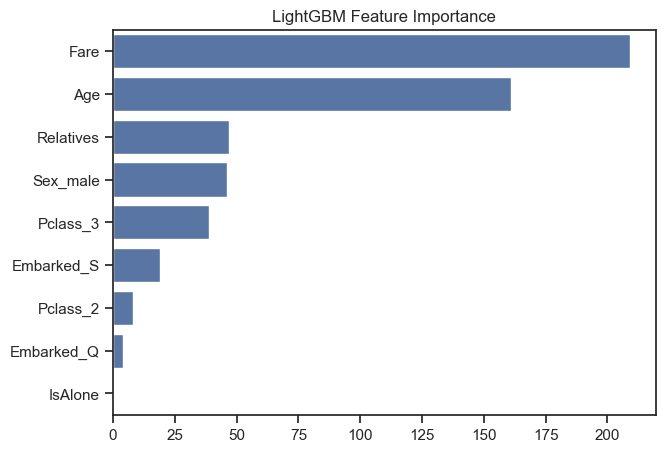

In [35]:
importances = best_lgbm_clf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importances, orient="h")
plt.title("LightGBM Feature Importance")
plt.show()

### Тестирование модели и результаты по основным метрикам

In [36]:
y_pred = best_lgbm_clf.predict(X_test)
y_pred_proba = best_lgbm_clf.predict_proba(X_test)[:, 1]

Accuracy:  0.8379888268156425
Precision:  0.8082191780821918
Recall:  0.7972972972972973
F1:  0.8027210884353742
ROC-AUC:  0.8816602316602317


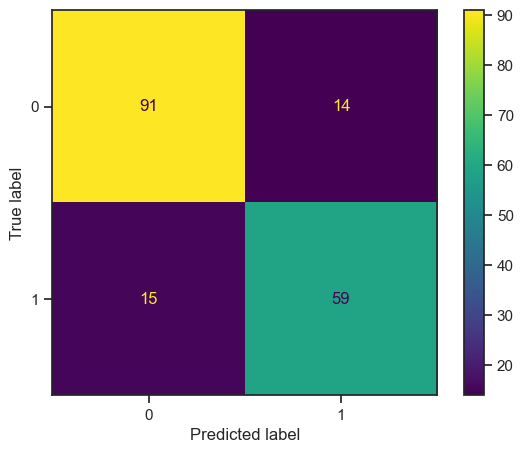

In [37]:
metrics_summary(y_pred, y_pred_proba, best_lgbm_clf)

### Kaggle Score

In [38]:
submission['Survived'] = best_lgbm_clf.predict(test_df)
submission.to_csv("data/submissions/lgbm_submission.csv", index=False)

![lgbm_submission](data/img/lgbm_submission.png)

# Модель XGBoost

### Подбор параметров с помощью кросс-валидации

In [39]:
start_time = time.time()
best_xgb_clf = find_best_parameters(X_train, y_train, XGBClassifier(verbosity=0))
end_time = time.time()
print("Общее время, затраченное на кросс-валидацию (в секундах):", end_time - start_time)

Лучшие параметры модели:  {'iterations': 5, 'learning_rate': 0.05, 'max_depth': 5}
Общее время, затраченное на кросс-валидацию (в секундах): 183.54538464546204


### Важность признаков

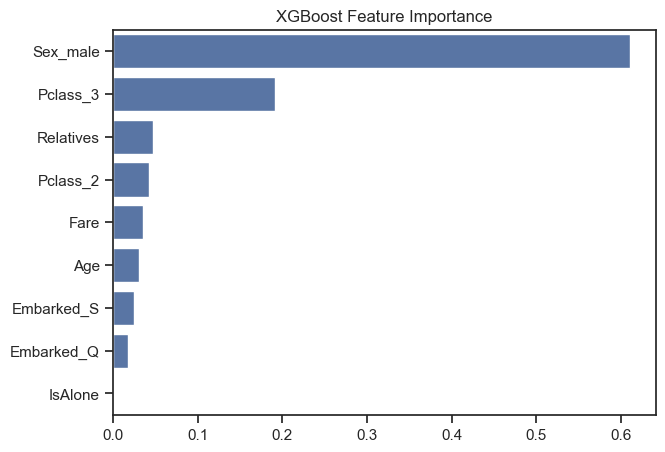

In [40]:
importances = best_xgb_clf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importances, orient="h")
plt.title("XGBoost Feature Importance")
plt.show()

### Тестирование модели и результаты по основным метрикам

In [41]:
y_pred = best_xgb_clf.predict(X_test)
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]

Accuracy:  0.8156424581005587
Precision:  0.8253968253968254
Recall:  0.7027027027027027
F1:  0.7591240875912408
ROC-AUC:  0.8967824967824969


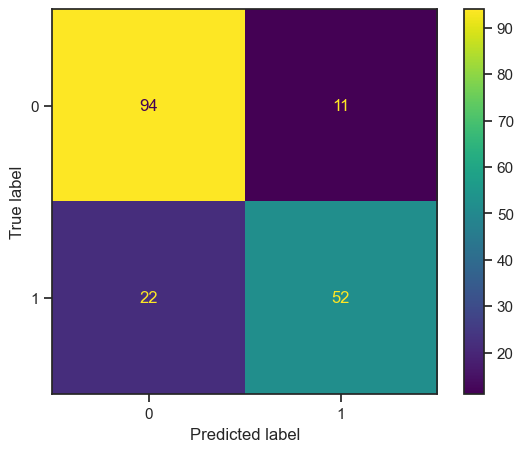

In [42]:
metrics_summary(y_pred, y_pred_proba, best_xgb_clf)

### Kaggle Score

In [43]:
submission['Survived'] = best_xgb_clf.predict(test_df)
submission.to_csv("data/submissions/xgb_submission.csv", index=False)

![xgb_submission](data/img/xgb_submission.png)

# Модель CatBoost

### Подбор параметров с помощью кросс-валидации

In [44]:
start_time = time.time()
best_catboost_clf = find_best_parameters(X_train, y_train, CatBoostClassifier(auto_class_weights='Balanced', loss_function='Logloss', verbose=False))
end_time = time.time()
print("Общее время, затраченное на кросс-валидацию (в секундах):", end_time - start_time)

Лучшие параметры модели:  {'iterations': 30, 'learning_rate': 0.05, 'max_depth': 7}
Общее время, затраченное на кросс-валидацию (в секундах): 1851.908196926117


### Важность признаков

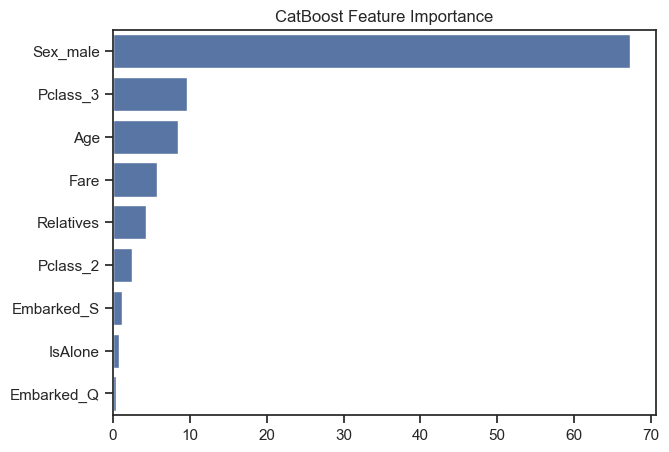

In [45]:
importances = best_catboost_clf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_importances, orient="h")
plt.title("CatBoost Feature Importance")
plt.show()

### Тестирование модели и результаты по основным метрикам

In [46]:
y_pred = best_catboost_clf.predict(X_test)
y_pred_proba = best_catboost_clf.predict_proba(X_test)[:, 1]

Accuracy:  0.8156424581005587
Precision:  0.8059701492537313
Recall:  0.7297297297297297
F1:  0.7659574468085106
ROC-AUC:  0.8862934362934363


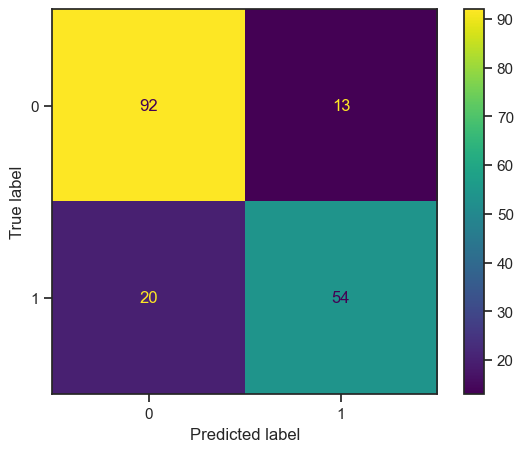

In [47]:
metrics_summary(y_pred, y_pred_proba, best_catboost_clf)

### Kaggle Score

In [48]:
submission['Survived'] = best_catboost_clf.predict(test_df)
submission.to_csv("data/submissions/catboost_submission.csv", index=False)

![catboost_submission](data/img/catboost_submission.png)

## Результаты

- Были использованы, 2 искусствено сгенерированных признака: IsAlone и Relatives;
- Для корректной обработки категориальных признаков были созданы фиктивные признаки;
- Признаки подверглись стандартизации;
- Были построены 3 модели градиетного бустинга с использованием библиотек LightGBM, XGBoost и CatBoost;
- Для поиска лучших параметров моделей использовался метод GridSearchCV библиотеки scikit-learn;
- Точность моделей находится примерно на одном уровне, CatBoost занимает первое место;
- По времени выполнения кросс-валидации, CatBoost занимает последнее место с временем выполнения в 30 минут. Параметры LightGBM и XGBoost подбирались в течении примерно 1.5 минут.

## Итоговые показатели метрики Accuracy для каждой модели на тестовой выборке

- **_LightGBM_** - 0.77272
- **_XGBoost_** - 0.77033
- **_CatBoost_** - 0.78468